In [1]:
import sys 
sys.path.append('../scripts/')
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
from utils_draw import *
import warnings
warnings.filterwarnings('ignore')
np.random.seed(7)

In [2]:
# 矩阵设计
A = np.array([[1, 1], [0, 1]]) # 状态矩阵
Q = np.array([[0.05, 0], [0, 0.05]]) # 状态误差矩阵
H = np.array([[1, 0], [0, 1]]) # 观测矩阵
R = np.array([[0.1, 0], [0, 0.1]]) # 观测误差矩阵
I = np.array([[1, 0], [0, 1]]) # 单位矩阵
Pposterior = np.array([[1, 0], [0, 1]]) # 初始先验误差协方差矩阵

In [3]:
# 获取噪声高斯分布获取
state_noise_pdf = multivariate_normal(cov=Q) # 获取状态变化量的高斯分布(这里的变化量由噪声引起)
measurement_noise_pdf = multivariate_normal(cov=R) # 获取观测变化量的高斯分布(这里的变化量由噪声引起)

In [4]:
# 通过高斯分布模拟仿真环境，获取真实值，状态估计值以及观测值
def get_simulation_data(x, y, m, state_noise_pdf, measurement_noise_pdf): # x,y指代初始的位置和速度；m指代总steps数
    Xinitial = np.array([[x], [y]]) # 初始化第一次状态矩阵
    actuals = []
    states = []
    measurements = []
    actuals.append(Xinitial.tolist())
    # 遍历，获取每次step的真实值，状态估计值和观测值
    for i in range(m):
        states.append(np.dot(A, Xinitial))
        Xinitial = np.dot(A, Xinitial) + np.mat(state_noise_pdf.rvs()).T
        measurements.append((Xinitial + np.mat(measurement_noise_pdf.rvs()).T).tolist())
        actuals.append(Xinitial.tolist())
    return actuals, measurements, states

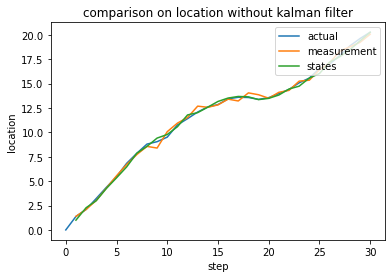

In [5]:
x=0;y=1;m=30
actuals, measurements, states = get_simulation_data(x, y, m, state_noise_pdf, measurement_noise_pdf)
draw_location(actuals, measurements, states)

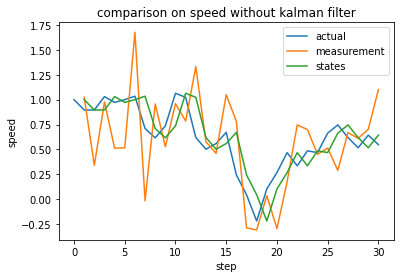

In [6]:
draw_speed(actuals, measurements, states)

In [7]:
# 卡尔曼过滤器设计
# x1为实际位置，x2为实际速度
def kalman(x1First, x2First, Z, Pposterior, Q, R):
    # 初始化第一次后验估计值
    XposteriorLast = np.array([[x1First], [x2First]])
    # 初始化第一次先验误差协方差矩阵
    PposteriorLast = Pposterior
    # 先验估计值集合
    prior = []
    # 后验估计值集合
    posterior = []
    Pps = []
    posterior.append(XposteriorLast)
    for i in range(len(Z)):
        # 预测环节
        # 求解这一次先验估计值
        XpriorCur = np.dot(A, XposteriorLast)
        # 记录这一次先验估计值
        prior.append(XpriorCur)
        # 求解这一次先验误差协方差矩阵
        PpriorCur = np.dot(A, PposteriorLast)
        PpriorCur = np.dot(PpriorCur, A.T) + Q

        # 校正环节
        # 求解卡尔曼增益
        Kk = G(PpriorCur, R)
        # 求解这一次后验估计值
        XposteriorCur = backJustify(XpriorCur, Kk, Z[i])
        # 记录这一次后验估计值
        posterior.append(XposteriorCur)
        # 求解下一次误差协方差矩阵
        P = (I - np.dot(Kk, H))
        P = np.dot(P, PpriorCur)

        # 更新环节
        # 更新后验误差协方差矩阵
        PposteriorLast = P
        # 更新后验估计值
        XposteriorLast = XposteriorCur
    return prior, posterior

# 卡尔曼增益
def G(PpriorCur, R):
    tmp1 = np.dot(PpriorCur, H.T)
    tmp2 = np.dot(H, PpriorCur)
    tmp3 = np.dot(tmp2, H.T)
    tmp4 = tmp3 + R
    tmp4 = np.linalg.inv(tmp4)
    Kk = np.dot(tmp1, tmp4)
    return Kk

# 计算后验估计值
def backJustify(Xfristk, Kk, Zk):
    tmp1 = Zk - np.dot(H, Xfristk)
    tmp2 = np.dot(Kk, tmp1)
    Xlastk = Xfristk + tmp2
    return Xlastk

In [8]:
# 获取卡尔曼滤波下的后验值
prior, posterior= kalman(0, 1, measurements, Pposterior, Q, R)

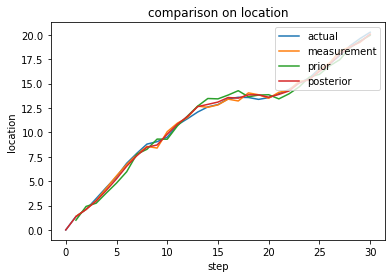

In [9]:
# 绘制出卡尔曼滤波下的位置变化
draw_location_kalman(actuals, measurements, prior, posterior)

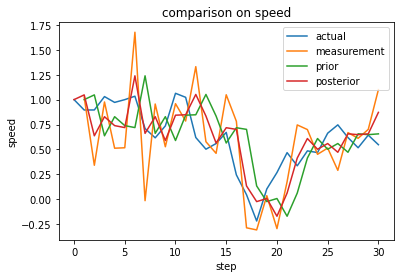

In [10]:
# 绘制出卡尔曼滤波下的速度变化
draw_speed_kalman(actuals, measurements, prior, posterior)